$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\Xvh}{\hat{\mathbf{X}}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uu}{\mathbf{U}}
\newcommand{\uu}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z1}}
\newcommand{\Zzv}{\mathbf{Z2}}
\newcommand{\Zvh}{\hat{\mathbf{Z1}}}
\newcommand{\Zzvh}{\hat{\mathbf{Z2}}}
\newcommand{\Ev}{\mathbf{E}}
\newcommand{\onev}{\mathbf{1}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$


# Three-Layer Neural Network


## Matrix Equations

Matrix equations for a network with two hidden layer.

$$ 
\begin{align*}
N &= \text{ number of samples } \\
I &= \text{ the number of attributes in each sample }\\
K &= \text{ number of units in output layer } \\
H_1 &= \text{ number of units in first hidden layer }\\
H_2 &= \text{ number of units in second hidden layer }\\
~\\
\Zv &= \tanh(\Xvh\, \Uu) \\
\Zzv &= \tanh(\Zzvh\, \Vv) \\
\Yv &= \Zzvh\, \Wv\\
\Ev &= \frac{1}{N} (\Tv - \Yv)^T (\Tv - \Yv)  \\
\nabla_\Yv E_{n,k} &= \frac{-2}{NK} (\Tv_{n,k} - \Yv_{n,k})\\
\delta_\Yv &= \frac{-2}{NK} (\Tv - \Yv)\\
\nabla_\Wv E &=  \underbrace{\underbrace{\Zzvh^T}_{H2+1\times N} \underbrace{\delta_\Yv}_{N\times K}}_{H2+1\times K}\\
\nabla_\Vv E &= \underbrace{\underbrace{\Zvh^T}_{H2+1\times N} \; \underbrace{\delta_\Zzv}_{N\times H2}}_{H2+1\times H2} \;\;\;\;\text{ where } \delta_\Zzv = (\delta_\Yv \; \Wv_{1:}^T)\; \cdot\; (1-\Zzv^2) \;\;\;\; \text{ if } f(\Zzvh \Vv) = \tanh(\Zzvh \Vv)\\
\nabla_\Uu E &= \underbrace{\underbrace{\Xvh^T}_{I+1\times N} \; \underbrace{\delta_\Zv}_{N\times H1}}_{I+1\times H1} \;\;\;\;\text{ where } \delta_\Zv = (\delta_\Zzv \; \Vv_{1:}^T)\; \cdot\; (1-\Zv^2) \;\;\;\; \text{ if } f(\Zvh \Xv) = \tanh(\Zvh \Xv)\\
\end{align*}
$$



#### Defining network, error_gradient and mse funcitons

In [1]:
def network(w, n_inputs, n_hiddens_1,n_hiddens_2, n_outputs, X, all_outputs=False):
    n_U = (n_inputs+1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    n_W = (n_hiddens_2 + 1) * n_outputs
    U = w[:n_U].reshape((n_inputs + 1, n_hiddens_1))
    V = w[n_U:n_V+n_U].reshape((n_hiddens_1 + 1, n_hiddens_2))
    W = w[n_V+n_U:].reshape((n_hiddens_2 + 1, n_outputs))
    Z1 = np.tanh(U[0:1, :] + X @ U[1:, :])
    Z2 = np.tanh(V[0:1, :] + Z1 @ V[1:, :])
    Y = W[0:1, :] + Z2 @ W[1:, :]
    return (Y, Z1, Z2) if all_outputs else Y

def error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1,n_hiddens_2, n_outputs, X, all_outputs=True)
    n_samples = X.shape[0]
    delta_Y = -2 / (n_samples * n_outputs) * (T - Y)
    Z2_hat = np.insert(Z2, 0, 1, axis=1)
    dEdW = Z2_hat.T @ delta_Y
    n_U = (n_inputs+1) * n_hiddens_1
    n_W = (n_hiddens_2 + 1) * n_outputs
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    W = w[-n_W:].reshape((n_hiddens_2 + 1, n_outputs))
    delta_Z2 = (delta_Y @ W[1:, :].T) * (1 - Z2**2)
    
    Z1_hat = np.insert(Z1, 0, 1, axis=1)
    dEdV= Z1_hat.T @ delta_Z2
    
    V = w[n_U:n_V+n_U].reshape((n_hiddens_1 + 1, n_hiddens_2))
    delta_Z1 = (delta_Z2 @ V[1:, :].T) * (1 - Z1**2)
    
    X_hat = np.insert(X, 0, 1, axis=1)
    dEdU = X_hat.T @ delta_Z1
 
    dEdw = np.hstack((dEdU.flatten(), dEdV.flatten(), dEdW.flatten()))

    return dEdw

def mse(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y = network(w, n_inputs, n_hiddens_1,n_hiddens_2, n_outputs, X)
    return np.mean((T - Y)**2)

## Testing on Air Quality Data
Rredicting CO from the Hour of the day.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas
import optimizers as opt  # from Lecture Notes

In [3]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23 * 20]  # first 20 days of data
data = data.dropna(axis=0)
print('data.shape =', data.shape)

hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)
np.hstack((X, T))[:10]  # show the first 10 samples of hour, CO

data.shape = (443, 2)


array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]])

In [4]:
n_inputs = X.shape[1]
n_hiddens_1 = 5
n_hiddens_2 = 5
n_outputs = T.shape[1]


Defining Initial Weight Vectors

In [5]:
n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1



Standardising the Input Values(mean=0)

In [6]:
standardize = True

if standardize:
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    
    X = (X - X_mean) / X_std


Now we can train our network using each of the three optimization algorithms.

In [7]:
n_iterations = 1000

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 1.253 and it took 0.35 seconds
Adam final error is 1.246 and it took 0.41 seconds
SCG final error is 0.911 and it took 0.78 seconds


Examining the error curve and the model fits for each of the optimization algorithms.

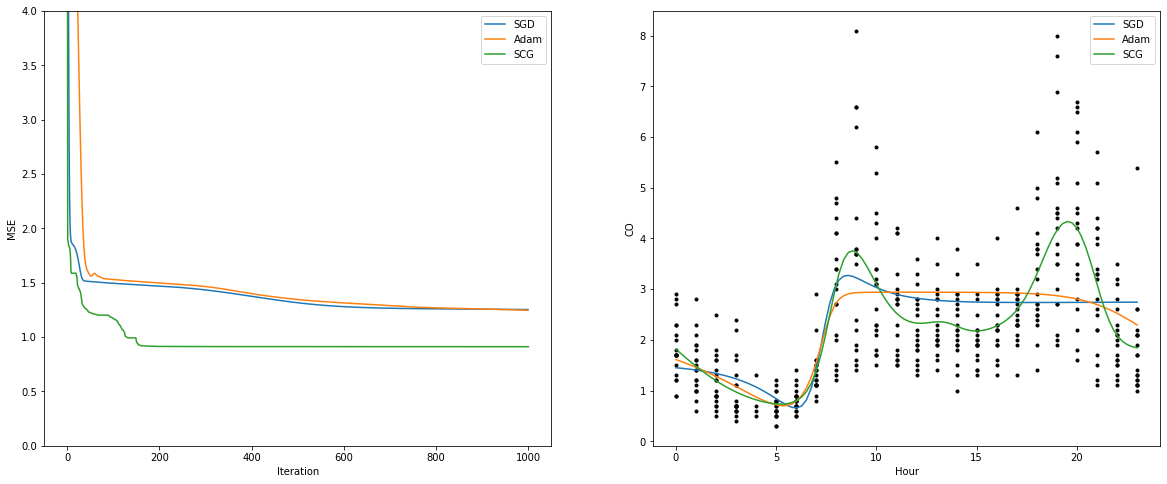

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(result_sgd['ftrace'], label='SGD')
plt.plot(result_adam['ftrace'], label='Adam')
plt.plot(result_scg['ftrace'], label='SCG')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.ylim(0, 4)

plt.subplot(1, 2, 2)
if standardize:
    plt.plot(X * X_std + X_mean, T, 'k.')  # unstandardize X
else:
    plt.plot(X, T, 'k.')
xs = np.linspace(0, 23, 100).reshape((-1, 1))
xs_standardized = (xs - X_mean) / X_std if standardize else xs
plt.plot(xs, network(result_sgd['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SGD')
plt.plot(xs, network(result_adam['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='Adam')
plt.plot(xs, network(result_scg['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SCG')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('CO');

#### Discussion

As we increase the number of iterations SGD shows up more wayward errors because of certain CO values that aren't in the cluster, i.e. the sometimes unexpected higher level of CO values show up. It is so because, as the number of iterations are increased the SGD starts to consider lot more of values than it does with lower number of iterations which sometimes results in getting deviated from the desired value resulting in higher error.

#### Results

In [9]:
results = []
for n_iterations in [20, 1000]:
    for nh1 in [2, 3]:
        for nh2 in [2, 3]:
            
            n_U = (n_inputs + 1) * nh1
            n_V = (nh1 + 1) * nh2
            n_W = (nh2 + 1) * n_outputs
            initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)

            result_scg = opt.scg(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                 n_iterations=n_iterations)
            results.append([n_iterations, nh1, nh2, 0, 'scg', result_scg['ftrace'][-1]])
            
            for lr in [1e-1, 1e-4]:
                
                result_sgd = opt.sgd(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=lr, momentum_rate=0)
                result_adam = opt.adam(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                       n_iterations=n_iterations, learning_rate=lr)
 
                results.append([n_iterations, nh1, nh2, lr, 'sgd', result_sgd['ftrace'][-1]])
                results.append([n_iterations, nh1, nh2, lr, 'adam', result_adam['ftrace'][-1]])

results = pandas.DataFrame(results, columns=('Iterations', 'nh1', 'nh2', 'lr', 'algo', 'mse'))
results

,Iterations,nh1,nh2,lr,algo,mse
0,20,2,2,0.0000,scg,1.680594
1,20,2,2,0.1000,sgd,1.884572
2,20,2,2,0.1000,adam,1.794808
3,20,2,2,0.0001,sgd,7.580486
4,20,2,2,0.0001,adam,7.612139
5,20,2,3,0.0000,scg,1.445049
6,20,2,3,0.1000,sgd,1.883025
7,20,2,3,0.1000,adam,1.591374
8,20,2,3,0.0001,sgd,6.827272
9,20,2,3,0.0001,adam,6.853491


#### Results for the 20 lowest MSE values, sorted by increasing MSE.

In [10]:
results.sort_values(by='mse').head(20)

,Iterations,nh1,nh2,lr,algo,mse
37,1000,3,3,0.1,adam,0.914939
35,1000,3,3,0.0,scg,0.917991
27,1000,2,3,0.1,adam,0.961110
32,1000,3,2,0.1,adam,1.163115
30,1000,3,2,0.0,scg,1.221648
25,1000,2,3,0.0,scg,1.221734
20,1000,2,2,0.0,scg,1.222273
22,1000,2,2,0.1,adam,1.261663
31,1000,3,2,0.1,sgd,1.262658
36,1000,3,3,0.1,sgd,1.262838


#### Discussion

As we see the learning rate of scg is faster than sgd and adam algorithms.

SGD's give better results when the number of iterations are higher and when they are low, say 20, the error is significantly higher.

SCG performs significantly better irrespective of the number of iterations and it is quicker to adapt from one step to another.

The adaptibility term used is with respect to the performance of the algorithm with respect to the difference in the number of unites in First and Second Hidden Layer.

SCG and ADAM seem to perform significantly better when the number of units of First and Second Hidden Layers are the same and end up generating higher errors when they aren't.

#### Testing the code for 3 attributes for each of 5 samples and two output values for each sample.

In [11]:
X = np.arange(15).reshape((5, 3))
T = np.hstack((X[:, 0:1] * 0.1 * X[:, 1:2], X[:, 2:]**2)) # making two target values for each sample
T = T.reshape((5, 2))
print('  Input            Target')
for x, t in zip(X, T):
    print(x, '\t', t)

  Input            Target
[0 1 2] 	 [0. 4.]
[3 4 5] 	 [ 1.2 25. ]
[6 7 8] 	 [ 4.2 64. ]
[ 9 10 11] 	 [  9. 121.]
[12 13 14] 	 [ 15.6 196. ]


##### 50 units in the first hidden layer and 3 units in the second hidden layer.

In [12]:
n_hiddens_1 = 50
n_hiddens_2 = 3
n_iterations = 2000


n_inputs = X.shape[1]
n_outputs = T.shape[1]

n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

standardize = True

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 2433.744 and it took 0.30 seconds
Adam final error is 2187.394 and it took 0.39 seconds
SCG final error is 0.008 and it took 0.56 seconds


In [13]:
w = result_scg['w']

Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
Y.shape

(5, 2)

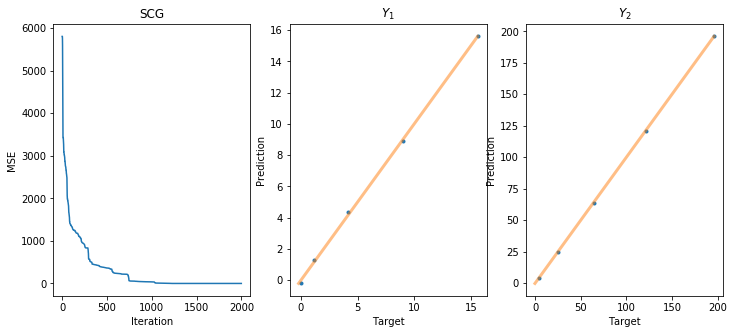

In [14]:
def plot_diagonal(T, Y):
    a = min(T.min(), Y.min())
    b = max(T.max(), Y.max())
    plt.plot([a, b], [a, b], '-', lw=3, alpha=0.5)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(result_scg['ftrace'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('SCG')

plt.subplot(1, 3, 2)
plt.plot(T[:, 0], Y[:, 0], '.')
plot_diagonal(T[:, 0], Y[:, 0])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_1$')

plt.subplot(1, 3, 3)
plt.plot(T[:, 1], Y[:, 1], '.')
plot_diagonal(T[:, 1], Y[: 1])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_2$');

#### Discussion

It's clear that the adaptive ability of SCG is significantly better than SCG and ADAM algorithms. 

We can also see the errors of SGD and ADAM blow up when the number of units between First and Second Hidden Layer are different.